# ======== Phase 1 ========

## Libraries and Packages

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt     
import seaborn as sns

import string
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   
from wordcloud import WordCloud, STOPWORDS

from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM
from keras.layers import Convolution1D, GlobalMaxPooling1D,GlobalAveragePooling1D
from keras.layers import Bidirectional, SpatialDropout1D, GRU
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import model_selection
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.optimizers import RMSprop, Adam

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import gc
## warnings
import warnings
warnings.filterwarnings("ignore")

## Data

In [2]:
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')

## Exploratory Data Analysis

In [3]:
# Missing values
train.isnull().sum()

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [4]:
print(train.shape, '\n')
train.info()

(1804874, 45) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual    

In [5]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


### Visualizing Non-null Target distribuition

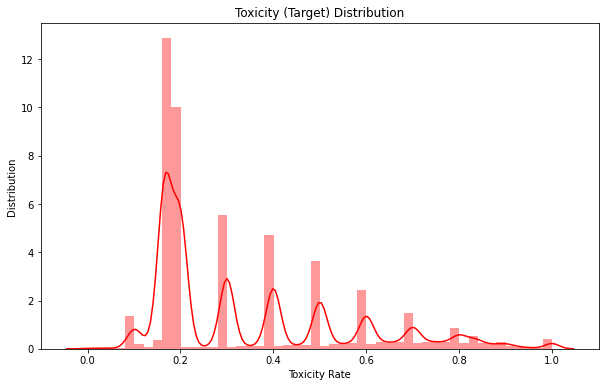

In [6]:
plt.figure(figsize=(10,6))
graph_1 = sns.distplot(train[train['target'] > 0]['target'], color = 'red')
plt.title('Toxicity (Target) Distribution')
plt.xlabel("Toxicity Rate")
plt.ylabel("Distribution") 
plt.show()

### Non-null Sub-classes Distribution

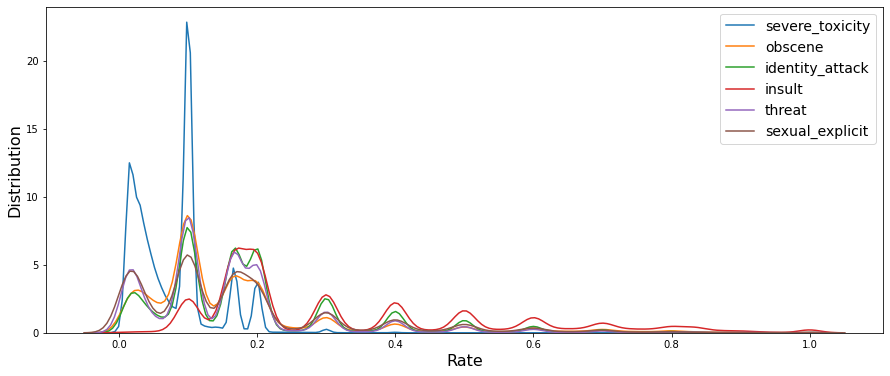

In [7]:
comment_adjective = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']

plt.figure(figsize=(15,6))

for col in comment_adjective:
    graph_2 = sns.distplot(train[train[col] > 0][col], label=col, hist=False)
    plt.xlabel("Rate", fontsize=16)
    plt.ylabel("Distribution", fontsize=16)
    plt.legend(loc=1, prop={'size': 14})

plt.show()

# ======== Phase 2 ========

# Data Pre-processing

### Embeddings

GloVe pre-trained word vectors: https://www.kaggle.com/tides94/pickled-glove-6b-300d

6B tokens, 300d vectors

In [8]:
#!mkdir '/root/.kaggle'

In [9]:
#!cp '../input/my-json/kaggle.json' '/root/.kaggle'

In [10]:
#!kaggle datasets download -d danielwillgeorge/glove6b100dtxt

In [11]:
#!unzip "./glove6b100dtxt.zip"

In [12]:
#!rm "./pickled-glove840b300d-for-10sec-loading.zip"

In [13]:
""" GLOVE_EMBEDDING_PATH = "./glove.6B.100d.txt"

import pickle

def load_embeddings(path):
    with open(path,'rb') as f:
        emb_arr = pickle.load(f)
    return emb_arr

glove_embeddings = load_embeddings(GLOVE_EMBEDDING_PATH)
print('Found and loaded {} word vectors'.format(len(glove_embeddings)))

#!rm "./glove.840B.300d.pkl"

"check_coverage" goes through a given vocabulary and tries to find word vectors in embedding matrix. "build_vocab" builds a ordered dictionary of words and their frequency in the text corpus.

import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose =  True):
    """ """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """ """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

vocab = build_vocab(list(train['comment_text'].apply(lambda x:x.split())))
oov = check_coverage(vocab,glove_embeddings)
oov[:10]

### Symbols in GloVe

import string
letter_digit_list = string.ascii_letters + string.digits + ' '
letter_digit_list += "'"

Symbols that have embedding vectors in GloVe:

glove_chars = ''.join([c for c in tqdm(glove_embeddings) if len(c) == 1])
glove_symbols = ''.join([c for c in glove_chars if not c in letter_digit_list])
glove_symbols

Symbols that have no embedding vectors in GloVe:

jigsaw_chars = build_vocab(list(train["comment_text"]))

jigsaw_symbols = ''.join([c for c in jigsaw_chars if not c in letter_digit_list])
jigsaw_symbols

symbols_to_delete = ''.join([c for c in jigsaw_symbols if not c in glove_symbols])
symbols_to_delete

symbols_to_isolate = ''.join([c for c in jigsaw_symbols if c in glove_symbols])
symbols_to_isolate

del glove_embeddings
del vocab
del glove_chars
del glove_symbols

gc.collect() """

' GLOVE_EMBEDDING_PATH = "./glove.6B.100d.txt"\n\nimport pickle\n\ndef load_embeddings(path):\n    with open(path,\'rb\') as f:\n        emb_arr = pickle.load(f)\n    return emb_arr\n\nglove_embeddings = load_embeddings(GLOVE_EMBEDDING_PATH)\nprint(\'Found and loaded {} word vectors\'.format(len(glove_embeddings)))\n\n#!rm "./glove.840B.300d.pkl"\n\n"check_coverage" goes through a given vocabulary and tries to find word vectors in embedding matrix. "build_vocab" builds a ordered dictionary of words and their frequency in the text corpus.\n\nimport operator \n\ndef check_coverage(vocab,embeddings_index):\n    a = {}\n    oov = {}\n    k = 0\n    i = 0\n    for word in tqdm(vocab):\n        try:\n            a[word] = embeddings_index[word]\n            k += vocab[word]\n        except:\n\n            oov[word] = vocab[word]\n            i += vocab[word]\n            pass\n\n    print(\'Found embeddings for {:.2%} of vocab\'.format(len(a) / len(vocab)))\n    print(\'Found embeddings for 

In [14]:
#from nltk.tokenize.treebank import TreebankWordTokenizer
#tokenizer = TreebankWordTokenizer()


#isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
#remove_dict = {ord(c):f'' for c in symbols_to_delete}


""" def handle_punctuation(x):
    x = x.replace(remove_dict)
    x = x.replace(isolate_dict)
    return x """

"""def handle_punctuation(x):
    x = x.translate(remove_dict)
    x = x.translate(isolate_dict)
    return x """
def cleaning_text(x):
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    x = clean_special_chars(x, punct)
    return x

"""def handle_contractions(x):
    x = tokenizer.tokenize(x)
    return x """

def fix_quote(x):
    x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
    x = ' '.join(x)
    return x

def preprocess(x):
    #x = handle_punctuation(x)
    x = cleaning_text(x)
    #x = handle_contractions(x)
    x = fix_quote(x)
    return x

In [15]:
# Make sure all comment_text values are strings
train['comment_text'] = train['comment_text'].astype(str) 

# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

train = convert_dataframe_to_bool(train)

In [16]:
#train['comment_text'] = train['comment_text'].progress_apply(lambda x:preprocess(x))

In [17]:
train_df, validate_df = model_selection.train_test_split(train, test_size=0.2)
print('%d train comments, %d validate comments' % (len(train_df), len(validate_df)))

1443899 train comments, 360975 validate comments


### Padding Function

In [18]:
MAX_NUM_WORDS = 10000
TARGET_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 250
def pad_text(texts, tokenizer):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

In [19]:
"""
identity_columns = ['asian', 'atheist',
       'bisexual', 'black', 'buddhist', 'christian', 'female',
       'heterosexual', 'hindu', 'homosexual_gay_or_lesbian',
       'intellectual_or_learning_disability', 'jewish', 'latino', 'male',
       'muslim', 'other_disability', 'other_gender',
       'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white']
# Overall
weights = np.ones((len(train_df),)) / 4
# Subgroup
weights += (train_df[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4
# Background Positive, Subgroup Negative
weights += (( (train_df['target'].values>=0.5).astype(bool).astype(np.int) +
   (train_df[identity_columns].fillna(0).values<0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
# Background Negative, Subgroup Positive
weights += (( (train_df['target'].values<0.5).astype(bool).astype(np.int) +
   (train_df[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
loss_weight = 1.0 / weights.mean()
train_label = np.vstack([(train_df['target'].values>=0.5).astype(np.int),weights]).T
"""

"\nidentity_columns = ['asian', 'atheist',\n       'bisexual', 'black', 'buddhist', 'christian', 'female',\n       'heterosexual', 'hindu', 'homosexual_gay_or_lesbian',\n       'intellectual_or_learning_disability', 'jewish', 'latino', 'male',\n       'muslim', 'other_disability', 'other_gender',\n       'other_race_or_ethnicity', 'other_religion',\n       'other_sexual_orientation', 'physical_disability',\n       'psychiatric_or_mental_illness', 'transgender', 'white']\n# Overall\nweights = np.ones((len(train_df),)) / 4\n# Subgroup\nweights += (train_df[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4\n# Background Positive, Subgroup Negative\nweights += (( (train_df['target'].values>=0.5).astype(bool).astype(np.int) +\n   (train_df[identity_columns].fillna(0).values<0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4\n# Background Negative, Subgroup Positive\nweights += (( (train_df['target'].values<0.5).astype(bool

# ======== Phase 3 ========

# Pre-training Dataset

In [20]:
"""
!kaggle datasets download -d fizzbuzz/cleaned-toxic-comments

!unzip "./cleaned-toxic-comments.zip"

pre_data = "./train_preprocessed.csv"


## Get the Corpus of all the comments and related Toxicity fields

data = pd.read_csv(pre_data)
data.head()

## Dividing the dataset into features and labels:
Features = "comment"            
Labels = "toxicity"

Features = data['comment_text']
Labels = np.array([0 if y == 0 else 1 for y in data['toxicity']])

### Tokenizing and preprocessing the data

NUM_WORDS = 40000 # Maximum number of unique words which need to be tokenized
MAXLEN = 50 # Maximum length of a sentence/ comment
PADDING = 'post' # The type of padding done for sentences shorter than the Max len

tokenizer = Tokenizer(num_words=NUM_WORDS)

# Fit the tokenizer on the comments 
tokenizer.fit_on_texts(Features)

# Get the word index of the top 20000 words from the dataset
word_idx = tokenizer.word_index

# Convert the string sentence to a sequence of their numerical values
Feature_sequences = tokenizer.texts_to_sequences(Features)

# Pad the sequences to make them of uniform length
padded_sequences = pad_sequences(Feature_sequences, maxlen = MAXLEN, padding = PADDING)

print("The Transformation of sentence::")
print("\n\nThe normal Sentencen:\n")
print(Features[2])
print("\n\nThe tokenized sequence:\n")
print(Feature_sequences[2])
print("\n\nThe padded sequence:\n")
print(padded_sequences[2])

# Convert to array for passing through the model
X = np.array(padded_sequences)
"""

'\n!kaggle datasets download -d fizzbuzz/cleaned-toxic-comments\n\n!unzip "./cleaned-toxic-comments.zip"\n\npre_data = "./train_preprocessed.csv"\n\n\n## Get the Corpus of all the comments and related Toxicity fields\n\ndata = pd.read_csv(pre_data)\ndata.head()\n\n## Dividing the dataset into features and labels:\nFeatures = "comment"            \nLabels = "toxicity"\n\nFeatures = data[\'comment_text\']\nLabels = np.array([0 if y == 0 else 1 for y in data[\'toxicity\']])\n\n### Tokenizing and preprocessing the data\n\nNUM_WORDS = 40000 # Maximum number of unique words which need to be tokenized\nMAXLEN = 50 # Maximum length of a sentence/ comment\nPADDING = \'post\' # The type of padding done for sentences shorter than the Max len\n\ntokenizer = Tokenizer(num_words=NUM_WORDS)\n\n# Fit the tokenizer on the comments \ntokenizer.fit_on_texts(Features)\n\n# Get the word index of the top 20000 words from the dataset\nword_idx = tokenizer.word_index\n\n# Convert the string sentence to a sequ

# ======== Phase 4 ========

# Training

In [21]:
EMBEDDINGS_PATH = '../input/glove-6b-100d/glove.6B.100d.txt'
EMBEDDINGS_DIMENSION = 100
LEARNING_RATE = 0.0005
NUM_EPOCHS = 5
BATCH_SIZE = 128

# Prepare data
train_text = pad_text(train_df[TEXT_COLUMN], tokenizer)

In [22]:
train_label = to_categorical(train_df[TARGET_COLUMN])

In [23]:
del train
gc.collect()

40

In [24]:
X_train, X_test, y_train, y_test=train_test_split(train_text, train_label, test_size=0.20, random_state=42)

In [25]:
gc.collect()

40

### Embedding Matrix

In [26]:
# Load embeddings
print('loading embeddings')
embeddings_index = {}
with open(EMBEDDINGS_PATH) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,
                                 EMBEDDINGS_DIMENSION))
num_words_in_embedding = 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        num_words_in_embedding += 1
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print("Embeddings loaded!")

loading embeddings
Embeddings loaded!


In [27]:
# Create model layers.
model=Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1,100,input_length = 100,weights = [embedding_matrix],trainable = False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(GlobalAveragePooling1D())
model.add(Dense(512,activation = 'relu'))
model.add(Dense(512,activation = 'relu'))
model.add(Dense(2,activation='softmax'))

# Compile model.
print('Compiling model...')
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=LEARNING_RATE),
                  metrics=['acc'])
print("Compiled model!")

Compiling model...
Compiled model!


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          39770900  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          394240    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2

## Pre-training on external data

In [29]:
"""
history = model.fit(
            X, 
            Labels,
            batch_size = 128,
            epochs = 10,
            validation_split = 0.2, # 20 percent data reserved for validation to avoid or monitor overfitting/ underfitting
            verbose = verbose,
        )
"""

'\nhistory = model.fit(\n            X, \n            Labels,\n            batch_size = 128,\n            epochs = 10,\n            validation_split = 0.2, # 20 percent data reserved for validation to avoid or monitor overfitting/ underfitting\n            verbose = verbose,\n        )\n'

## Final Training on competition data

In [30]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_lstm_toxic.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [31]:
import time

In [32]:
# Train model.
print('Training model...')
start = time.time()
history = model.fit(X_train,
              y_train,
              batch_size=BATCH_SIZE,
              epochs= 1, #NUM_EPOCHS,
              validation_data=(X_test, y_test),
              verbose=1, callbacks = [model_checkpoint_callback])

end = time.time()
print("Training duration: {} minutes".format(str((end-start)/60)))

Training model...
9025/9025 [==============================] - 926s 102ms/step - loss: 0.2033 - acc: 0.9316 - val_loss: 0.1480 - val_acc: 0.9461
Training duration: 15.452413904666901 minutes


In [33]:
MODEL_NAME = 'my_model'
validate_df[MODEL_NAME] = model.predict(pad_text(validate_df[TEXT_COLUMN], tokenizer))[:, 1]

In [34]:
validate_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,my_model
537354,900627,False,I have to call CRA just about daily for my job...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,3,0,0.0,0,6,0.000394
121690,390799,False,well traveled.,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,3,0,0.0,0,4,0.004037
1420684,5855226,False,Really cannot believe aboriginal people even t...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,1,0,0,0,4,0.0,0,6,0.004335
800715,5100643,False,If the annual withdrawal from the permanent fu...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,1,2,0.0,0,4,0.000461
1705235,6212741,False,Anything this province does ends up as a cluster.,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,1,4,0.0,0,4,0.021775


In [35]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns, MODEL_NAME, TARGET_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
6,black,3045,0.791388,0.746603,0.958699
2,homosexual_gay_or_lesbian,2166,0.802300,0.739165,0.963204
7,white,4914,0.807469,0.746134,0.964048
5,muslim,4208,0.821010,0.768144,0.961912
4,jewish,1525,0.847376,0.838008,0.943097
8,psychiatric_or_mental_illness,989,0.864263,0.840978,0.947512
0,male,8834,0.879578,0.868728,0.941467
1,female,10717,0.881003,0.877640,0.937122
3,christian,8053,0.904091,0.904367,0.933103


In [36]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TARGET_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
get_final_metric(bias_metrics_df, calculate_overall_auc(validate_df, MODEL_NAME))

0.8799928653352884

In [37]:
del X_train, y_train, X_test, y_test
gc.collect()

736

In [38]:
#model.save('../toxicity_classifier.h5')

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [41]:
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')
submission = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv', index_col='id')

In [42]:
submission['prediction'] = model.predict(pad_text(test[TEXT_COLUMN], tokenizer))[:, 1]
submission.to_csv('submission.csv')